# Models

## Imports

In [1]:
import sys
import pandas as pd

# to save results to data directory
module_path = ".."
if module_path not in sys.path:
    sys.path.insert(1, module_path)
# increase displayed columns in jupyter notebook
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 300)

In [2]:
import dill
import numpy as np
import matplotlib.pyplot as plt

import h2o
from h2o.automl import H2OAutoML

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from pytorch_widedeep.dataloaders import DataLoaderImbalanced
from pytorch_widedeep.models import TabMlp, TabTransformer, WideDeep, TabNet
from pytorch_widedeep.bayesian_models import BayesianTabMlp
from pytorch_widedeep.training.bayesian_trainer import BayesianTrainer
from pytorch_widedeep.training import Trainer
from pytorch_widedeep.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    LRHistory,
    Callback,
)
from pytorch_widedeep.initializers import (
    XavierNormal,
)
from torch.optim import Adam, SGD, lr_scheduler  # , NAdam

from ray import tune
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune import JupyterNotebookReporter
from ray.tune.integration.wandb import WandbLoggerCallback, wandb_mixin
import wandb

import src.utils as utils
from src import pytorch_widedeep_explainer
from src import lightgbm_explainer
import src.common as common

import lightgbm as lgbm

import tracemalloc
import warnings
from typing import Optional, Dict
from sklearn.linear_model import LogisticRegression

tracemalloc.start()
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from scipy import special


class RayTuneReporter(Callback):
    r"""Callback that allows reporting history and lr_history values to RayTune
    during Hyperparameter tuning

    Callbacks are passed as input parameters to the ``Trainer`` class. See
    :class:`pytorch_widedeep.trainer.Trainer`

    For examples see the examples folder at:

        .. code-block:: bash

            /examples/12_HyperParameter_tuning_w_RayTune.ipynb
    """

    def on_epoch_end(
        self, epoch: int, logs: Optional[Dict] = None, metric: Optional[float] = None
    ):
        report_dict = {}
        for k, v in self.trainer.history.items():
            report_dict.update({k: v[-1]})
        if hasattr(self.trainer, "lr_history"):
            for k, v in self.trainer.lr_history.items():
                report_dict.update({k: v[-1]})
        tune.report(report_dict)


class WnBReportBest(Callback):
    r"""Callback that allows reporting best performance of a run to WnB
    during Hyperparameter tuning. It is an adjusted pytorch_widedeep.callbacks.ModelCheckpoint
    with added WnB and removed checkpoint saving.

    Callbacks are passed as input parameters to the ``Trainer`` class.

    Parameters
    ----------
    wb: obj
        Weights&Biases API interface to report single best result usable for
        comparisson of multiple paramater combinations by, for example,
        `parallel coordinates
        <https://docs.wandb.ai/ref/app/features/panels/parallel-coordinates>`_.
        E.g W&B summary report `wandb.run.summary["best"]`.
    monitor: str, default="loss"
        quantity to monitor. Typically `'val_loss'` or metric name
        (e.g. `'val_acc'`)
    mode: str, default="auto"
        If ``save_best_only=True``, the decision to overwrite the current save
        file is made based on either the maximization or the minimization of
        the monitored quantity. For `'acc'`, this should be `'max'`, for
        `'loss'` this should be `'min'`, etc. In `'auto'` mode, the
        direction is automatically inferred from the name of the monitored
        quantity.

    """

    def __init__(
        self,
        wb: object,
        monitor: str = "val_loss",
        mode: str = "auto",
    ):
        super(WnBReportBest, self).__init__()

        self.monitor = monitor
        self.mode = mode
        self.wb = wb

        if self.mode not in ["auto", "min", "max"]:
            warnings.warn(
                "WnBReportBest mode %s is unknown, "
                "fallback to auto mode." % (self.mode),
                RuntimeWarning,
            )
            self.mode = "auto"
        if self.mode == "min":
            self.monitor_op = np.less
            self.best = np.Inf
        elif self.mode == "max":
            self.monitor_op = np.greater  # type: ignore[assignment]
            self.best = -np.Inf
        else:
            if self._is_metric(self.monitor):
                self.monitor_op = np.greater  # type: ignore[assignment]
                self.best = -np.Inf
            else:
                self.monitor_op = np.less
                self.best = np.Inf

    def on_epoch_end(  # noqa: C901
        self, epoch: int, logs: Optional[Dict] = None, metric: Optional[float] = None
    ):
        logs = logs or {}
        current = logs.get(self.monitor)
        if current is not None:
            if self.monitor_op(current, self.best):
                self.wb.run.summary["best"] = current  # type: ignore[attr-defined]
                self.best = current
                self.best_epoch = epoch

    @staticmethod
    def _is_metric(monitor: str):
        "copied from pytorch_widedeep.callbacks"
        if any([s in monitor for s in ["acc", "prec", "rec", "fscore", "f1", "f2"]]):
            return True
        else:
            return False

/home/palo/miniconda3/envs/ecce/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [3]:
column_types = common.json_load("../#datasets/Colab_PowerConverter/column_types.json")
target = column_types["target"]
identifier = column_types["identifier"]
measurement_label = column_types["measurement_label"]

parameters = {
    "random_state": 1,
    "valid_size": 0.2,
    "test_size": 0.5,
    "scaler_mapper_def": {
        "target_col": None,
        "identifier_col": None,
        "cont_cols": StandardScaler,
    },
}

valid_size = parameters["valid_size"]
test_size = parameters["test_size"]
scaler_mapper_def = parameters["scaler_mapper_def"]
random_state = parameters["random_state"]
test_n_valid_combined = True
task = "multiclass"  # (or "binary")

In [54]:
ioannis = True
if ioannis:
    target = "Target"
    # df = pd.read_csv("../#datasets/Colab_PowerConverter/PowerElectronics_11.csv")
    # df = pd.read_csv("../#datasets/Colab_PowerConverter/PowerElectronics_11_tampered_1_10.csv")
    # df_reduced = pd.read_csv("../#datasets/Colab_PowerConverter/PowerElectronics_11_tampered_1_10_reduced.csv")
    df = pd.read_csv(
        "../#datasets/Colab_PowerConverter/PowerElectronics_11_tampered_1_10_reduced.csv"
    )
    # df = pd.read_csv("../#datasets/Colab_PowerConverter/PowerElectronics_tampered_1_100.csv")
    # df = pd.read_csv("../#datasets/Colab_PowerConverter/PowerElectronics_tampered_1_100_reduced.csv")

    # df[df[target] == -1] = 3
    df[identifier] = df.index.values

    # temp = pd.merge(df, df_reduced, on=df_reduced.columns.values.tolist(), how="right")
    # df_reduced[identifier] = df_reduced.index.values
    # df_removed = df[~df["sample_id"].isin(temp["sample_id"].values.tolist())]

else:
    df = pd.read_pickle("../#datasets/Colab_PowerConverter/dataset.pkl")

**Ioannis datasets**
```
Fault.csv -> label 1
Fault2.csv -> label 2
DW_Transient.csv -> label 3 (also -1)
```

In [5]:
datasets = [
    "../#datasets/Colab_PowerConverter/PowerElectronics_11.csv",
    "../#datasets/Colab_PowerConverter/PowerElectronics_11_tampered_1_10.csv",
    "../#datasets/Colab_PowerConverter/PowerElectronics_11_tampered_1_10_reduced.csv",
    "../#datasets/Colab_PowerConverter/PowerElectronics_tampered_1_100.csv",
    "../#datasets/Colab_PowerConverter/PowerElectronics_tampered_1_100_reduced.csv",
]
for dataset_str in datasets:
    df_temp = pd.read_csv(dataset_str)
    print(df_temp["Target"].value_counts())
df_temp.head()

0    14000
2     5000
1     4000
3     1000
Name: Target, dtype: int64
0    14010
2     5000
1     3990
3     1000
Name: Target, dtype: int64
0    11653
2     3878
1     2236
3      693
Name: Target, dtype: int64
 2    5000
 1    3901
 0    2099
-1    1000
Name: Target, dtype: int64
 1    2120
 2    1939
 0     407
-1     252
Name: Target, dtype: int64


,URa,URb,URc,Udc,IRa,IRb,IRc,Target
0,-307.438,101.4930,205.946,599.277,0.300602,-1.295490,0.134279,0
1,-303.949,85.6335,218.316,601.601,0.416571,0.805675,-0.946058,0
2,-259.495,-21.7492,281.244,603.314,0.759898,-0.027466,-0.462348,0
3,-235.802,-59.0828,294.885,603.069,1.112380,0.785838,-0.277714,0
4,-221.591,-81.6662,303.257,601.846,0.384527,-0.579842,0.090028,0


**Keep only the faulty datasets as the other ones do not include fault**

In [6]:
if not ioannis:
    # this measurement did not have a fault (?)
    # df = df[df[measurement_label]!="Single-Phase_Sensor_Fault"]
    # df.reset_index(inplace=True, drop=True)

    df = df[
        df[measurement_label].isin(
            [
                "LL_Fault",
                "Three-Phase_Sensor_Fault",
                "Single_Phase_Sag",
                "Three_Phase_Grid_Fault",
            ]
        )
    ]
    df.reset_index(inplace=True, drop=True)

    fault_dict = {}
    for label, i in zip(
        df[measurement_label].unique(), range(len(df[measurement_label].unique()))
    ):
        df.loc[(df[measurement_label] == label) & (df[target] == 1), target] = int(
            i + 1
        )
        fault_dict[label] = int(i + 1)

    df.drop(columns=[measurement_label], inplace=True)
    print(f"imbalance of the classes:\n{df[target].value_counts()}")
    print(f"faults dictionary:\n{fault_dict}")

imbalance of the classes:
0    235539
2     40014
3     40001
1      3166
4      1335
Name: fault, dtype: int64
faults dictionary:
{'LL_Fault': 1, 'Three-Phase_Sensor_Fault': 2, 'Single_Phase_Sag': 3, 'Three_Phase_Grid_Fault': 4}


# Preprocessing
* divide dataset into train, test, valid
* scale continuous columns by standard scaler(not needed for LightGBM but for other mdoels...)

In [55]:
df_train, df_valid = train_test_split(
    df, test_size=valid_size, stratify=df[target], random_state=random_state
)
df_valid, df_test = train_test_split(
    df_valid, test_size=test_size, stratify=df_valid[target], random_state=random_state
)

df_train.reset_index(inplace=True, drop=True)
df_valid.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

cont_cols = df.drop(columns=[target, identifier]).columns.values
scaler = utils.scaler_mapper(
    cont_cols=cont_cols,
    target_col=target,
    identifier=identifier,
    scaler_mapper_def=scaler_mapper_def,
)

df_train_scaled = scaler.fit_transform(df_train)
df_test_scaled = scaler.transform(df_test)
df_valid_scaled = scaler.transform(df_valid)
# df_removed_scaled = scaler.transform(df_removed)

## Logistic Regression

In [56]:
LR_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs")
LR_clf.fit(df_train_scaled.drop(columns=[target, identifier]), df_train_scaled[target])
LR_predicted = LR_clf.predict(df_test_scaled.drop(columns=[target, identifier]))

print(
    "LR classification report :\n"
    + str(classification_report(df_test_scaled[target], LR_predicted))
)

LR classification report :
              precision    recall  f1-score   support

           0       0.68      1.00      0.81      1166
           1       0.96      0.61      0.75       224
           2       0.00      0.00      0.00       387
           3       0.00      0.00      0.00        69

    accuracy                           0.70      1846
   macro avg       0.41      0.40      0.39      1846
weighted avg       0.55      0.70      0.60      1846



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [80]:
y_onehot_test = pd.get_dummies(df_test_scaled[target]).values
y_score = LR_clf.predict_proba(df_test_scaled.drop(columns=[target, identifier]))

micro_roc_auc_ovr_per_class = roc_auc_score(
    y_onehot_test,
    y_score,
    multi_class="ovr",
    average=None,
)

micro_roc_auc_ovr_weighted = roc_auc_score(
    y_onehot_test,
    y_score,
    multi_class="ovr",
    average="weighted",
)

In [81]:
print(f"Per class AUC:\n{micro_roc_auc_ovr_per_class}")
print(f"Weighted AUC:\n{micro_roc_auc_ovr_weighted}")

Per class AUC:
[0.67770533 0.88608915 0.61713538 0.55476173]
Weighted AUC:
0.6856979051491241


# H2O AutoML

In [58]:
# initialize H2O
h2o.init(log_dir="h2o_logs", log_level="WARN")

# read as h2o file
h2o_train = h2o.H2OFrame(df_train_scaled.drop(columns=[identifier]))
h2o_valid = h2o.H2OFrame(df_valid_scaled.drop(columns=[identifier]))
h2o_test = h2o.H2OFrame(df_test_scaled.drop(columns=[identifier]))

# For binary classification, response should be a factor
h2o_train[target] = h2o_train[target].asfactor()
h2o_valid[target] = h2o_valid[target].asfactor()
h2o_test[target] = h2o_test[target].asfactor()

# Define AML task
aml = H2OAutoML(seed=random_state, max_runtime_secs=180)

# over/under sample for classification tasks
aml.balance_classes = True

# Run it
_ = aml.train(
    x=list(cont_cols),
    y=target,
    training_frame=h2o_train,
    leaderboard_frame=h2o_valid,
)

m = aml.get_best_model()

# Leaderboard, show and save
lb = h2o.automl.get_leaderboard(aml, extra_columns="ALL")
print(lb)
# save results
h2o.export_file(lb, path="h2o_logs/leaderboard.csv", force=True)

print(m.model_performance(h2o_valid))

# MOJO is h2o version agnostic
m.save_mojo("h2o_logs/bestmodel.zip")

predictions = m.predict(h2o_test)

Checking whether there is an H2O instance running at http://localhost:54321 .

 connected.


H2O_cluster_uptime:,32 mins 00 secs
H2O_cluster_timezone:,Europe/Madrid
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.4
H2O_cluster_version_age:,"1 year, 1 month and 16 days !!!"
H2O_cluster_name:,H2O_from_python_palo_0nggzg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.671 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                   mean_per_class_error    logloss      rmse        mse    training_time_ms    predict_time_per_row_ms  algo
XGBoost_1_AutoML_2_20240222_155921                                    0.0502034  0.0660041  0.145407  0.0211431                6206                   0.030901  XGBoost
StackedEnsemble_BestOfFamily_1_AutoML_2_20240222_155921               0.0511035  0.0516568  0.131115  0.0171912               11922                   0.120659  StackedEnsemble
GBM_1_AutoML_2_20240222_155921                                        0.0516278  0.0540262  0.134052  0.0179698

In [76]:
y_onehot_test = pd.get_dummies(df_test_scaled[target]).values
y_score = h2o.as_list(predictions.drop(["predict"])).values

micro_roc_auc_ovr_per_class = roc_auc_score(
    y_onehot_test,
    y_score,
    multi_class="ovr",
    average=None,
)

micro_roc_auc_ovr_weighted = roc_auc_score(
    y_onehot_test,
    y_score,
    multi_class="ovr",
    average="weighted",
)

In [78]:
print(f"Per class AUC:\n{micro_roc_auc_ovr_per_class}")
print(f"Weighted AUC:\n{micro_roc_auc_ovr_weighted}")

Per class AUC:
[0.99951695 0.99625407 0.99686522 0.99951881]
Weighted AUC:
0.9985651762921632


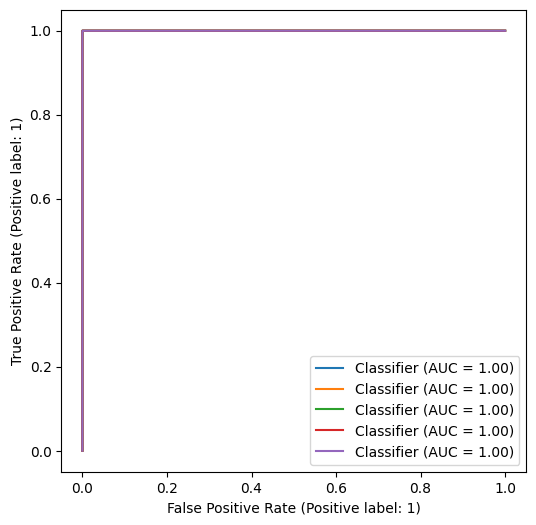

In [51]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

n_classes = 5

# colors = cycle(["aqua", "darkorange", "cornflowerblue"])
# for class_id, color in zip(range(n_classes), colors):
for class_id in range(n_classes):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        # name=f"ROC curve for {target_names[class_id]}",
        # color=color,
        ax=ax,
        # plot_chance_level=(class_id == 2),
    )

In [34]:
print(lb)
print(m.model_performance(h2o_valid))

model_id                                                   mean_per_class_error      logloss        rmse          mse    training_time_ms    predict_time_per_row_ms  algo
XGBoost_1_AutoML_1_20240222_152738                                   0.00150103  0.000606835  0.00832876  6.93683e-05               52998                   0.010979  XGBoost
GBM_1_AutoML_1_20240222_152738                                       0.00309357  0.0180328    0.0530207   0.00281119                50737                   0.039069  GBM
StackedEnsemble_BestOfFamily_1_AutoML_1_20240222_152738              0.208869    0.0342479    0.0817339   0.00668044                24497                   0.014816  StackedEnsemble
GLM_1_AutoML_1_20240222_152738                                       0.456278    0.369407     0.354796    0.12588                   50397                   0.000343  GLM
[4 rows x 8 columns]

ModelMetricsMultinomial: xgboost
** Reported on test data. **

MSE: 6.651136124431868e-05
RMSE: 0.0081554497879

In [59]:
print(
    "Classification report:\n{}".format(
        classification_report(h2o.as_list(predictions["predict"]), df_test[target])
    )
)

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1165
           1       0.88      0.91      0.90       216
           2       0.95      0.93      0.94       395
           3       0.97      0.96      0.96        70

    accuracy                           0.97      1846
   macro avg       0.95      0.95      0.95      1846
weighted avg       0.97      0.97      0.97      1846



# LightGBM

In [60]:
from scipy.misc import derivative


def focal_loss_lgb(y_pred, dtrain, alpha, gamma, num_class):
    """
    Focal Loss for lightgbm

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
    alpha, gamma: float
        See original paper https://arxiv.org/pdf/1708.02002.pdf
    num_class: int
        number of classes
    """
    a, g = alpha, gamma
    y_true = dtrain.label
    # N observations x num_class arrays
    y_true = np.eye(num_class)[y_true.astype("int")]
    y_pred = y_pred.reshape(-1, num_class, order="F")

    # alpha and gamma multiplicative factors with BCEWithLogitsLoss
    def fl(x, t):
        p = 1 / (1 + np.exp(-x))
        return (
            -(a * t + (1 - a) * (1 - t))
            * ((1 - (t * p + (1 - t) * (1 - p))) ** g)
            * (t * np.log(p) + (1 - t) * np.log(1 - p))
        )

    partial_fl = lambda x: fl(x, y_true)
    grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
    hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
    # flatten in column-major (Fortran-style) order
    return grad.flatten("F"), hess.flatten("F")


def focal_loss_lgb_eval_error(y_pred, dtrain, alpha, gamma, num_class):
    """
    Focal Loss for lightgbm

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
    alpha, gamma: float
        See original paper https://arxiv.org/pdf/1708.02002.pdf
    num_class: int
        number of classes
    """
    a, g = alpha, gamma
    y_true = dtrain.label
    y_true = np.eye(num_class)[y_true.astype("int")]
    y_pred = y_pred.reshape(-1, num_class, order="F")
    p = 1 / (1 + np.exp(-y_pred))
    loss = (
        -(a * y_true + (1 - a) * (1 - y_true))
        * ((1 - (y_true * p + (1 - y_true) * (1 - p))) ** g)
        * (y_true * np.log(p) + (1 - y_true) * np.log(1 - p))
    )
    # a variant can be np.sum(loss)/num_class
    return "focal_loss", np.mean(loss), False

In [61]:
n_class = pd.concat([df_train_scaled, df_valid_scaled, df_test_scaled])[
    target
].nunique()
custom = utils.LGBM_custom_score(n_class=n_class)
fobj = lambda preds, data: custom.lgbm_focal_loss(preds, data, 0.25, 1.0)
# feval = lambda preds, data: focal_loss_lgb_eval_error(preds, data, 0.25, 1.0, n_class)
feval = [
    lambda preds, data: [
        custom.lgbm_focal_loss_eval(preds, data, 0.25, 1.0),
        custom.lgbm_f1(preds, data),
        custom.lgbm_precision(preds, data),
        custom.lgbm_recall(preds, data),
        custom.lgbm_accuracy(preds, data),
    ]
]
# ray_metric = "-" + "focal_loss"
# ray_metric = "multi_logloss"

config = {}
config["objective"] = "multiclass"
config["num_classes"] = n_class

# config = {"verbose": -1}
# config["is_unbalance"] = True

In [87]:
df_train_scaled_enc = df_train_scaled.copy()
df_valid_scaled_enc = df_valid_scaled.copy()
df_test_scaled_enc = df_test_scaled.copy()
# df_removed_scaled_enc = df_removed_scaled.copy()
lgb_cat_cols = []

lgbtrain = lgbm.Dataset(
    df_train_scaled_enc.drop(columns=[target, identifier]),
    df_train_scaled_enc[target],
    categorical_feature=lgb_cat_cols,
    free_raw_data=False,
)
lgbvalid = lgbm.Dataset(
    df_valid_scaled_enc.drop(columns=[target, identifier]),
    df_valid_scaled_enc[target],
    reference=lgbtrain,
    free_raw_data=False,
)
# Final TRAIN/TEST
ftrain = pd.concat([df_train_scaled_enc, df_valid_scaled_enc]).reset_index(drop=True)
flgbtrain = lgbm.Dataset(
    ftrain.drop(columns=[target, identifier]),
    ftrain[target],
    categorical_feature=lgb_cat_cols,
    free_raw_data=False,
)
lgbtest = lgbm.Dataset(
    df_test_scaled_enc.drop(columns=[target, identifier]),
    df_test_scaled_enc[target],
    categorical_feature=lgb_cat_cols,
    reference=flgbtrain,
    free_raw_data=False,
)

# lgbremoved = lgbm.Dataset(
#     df_removed_scaled_enc.drop(columns=[target, identifier]),
#     df_removed_scaled_enc[target],
#     categorical_feature=lgb_cat_cols,
#     reference=flgbtrain,
#     free_raw_data=False,
# )

In [88]:
model = lgbm.train(
    config,
    lgbtrain,
    valid_sets=[lgbvalid],
    valid_names=[""],
    fobj=fobj,
    feval=feval,
)

Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is []


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 14768, number of used features: 7
[LightGBM] [Info] Start training from score -0.460085
[LightGBM] [Info] Start training from score -2.110806
[LightGBM] [Info] Start training from score -1.560093
[LightGBM] [Info] Start training from score -3.283053
[1]	's multi_logloss: 0.760325
[2]	's multi_logloss: 0.632489
[3]	's multi_logloss: 0.538497
[4]	's multi_logloss: 0.464912
[5]	's multi_logloss: 0.406175
[6]	's multi_logloss: 0.357475
[7]	's multi_logloss: 0.316564
[8]	's multi_logloss: 0.282834
[9]	's multi_logloss: 0.253767
[10]	's multi_logloss: 0.229642
[11]	's multi_logloss: 0.208774
[12]	's multi_logloss: 0.190503
[13]	's multi_logloss: 0.174691
[14]	's multi_logloss:

In [82]:
res = model.predict(lgbtest.data).argmax(1)
# res_removed = model.predict(lgbremoved.data).argmax(1)

result = pd.DataFrame(
    {
        "predicted": res,
        "ground_truth": df_test[target].values,
    }
)

print(
    "Classification report:\n{}".format(
        classification_report(result["predicted"], result["ground_truth"])
    )
)


# result_removed = pd.DataFrame(
#     {
#         "predicted": res_removed,
#         "ground_truth": df_removed[target].values,
#     }
# )

# print("Classification report for removed values:\n{}".format(classification_report(result_removed["predicted"], result_removed["ground_truth"])))

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1164
           1       0.88      0.93      0.91       213
           2       0.96      0.93      0.94       401
           3       0.97      0.99      0.98        68

    accuracy                           0.98      1846
   macro avg       0.95      0.96      0.96      1846
weighted avg       0.98      0.98      0.98      1846



In [90]:
# no focal loss
y_onehot_test = pd.get_dummies(df_test_scaled[target]).values
y_score = special.expit(model.predict(lgbtest.data))

micro_roc_auc_ovr_per_class = roc_auc_score(
    y_onehot_test,
    y_score,
    multi_class="ovr",
    average=None,
)

micro_roc_auc_ovr_weighted = roc_auc_score(
    y_onehot_test,
    y_score,
    multi_class="ovr",
    average="weighted",
)

print(f"Per class AUC:\n{micro_roc_auc_ovr_per_class}")
print(f"Weighted AUC:\n{micro_roc_auc_ovr_weighted}")

Per class AUC:
[0.99989532 0.99679904 0.99744967 0.99878479]
Weighted AUC:
0.9989653838467449


In [86]:
# focal loss
y_onehot_test = pd.get_dummies(df_test_scaled[target]).values
y_score = special.expit(model.predict(lgbtest.data))

micro_roc_auc_ovr_per_class = roc_auc_score(
    y_onehot_test,
    y_score,
    multi_class="ovr",
    average=None,
)

micro_roc_auc_ovr_weighted = roc_auc_score(
    y_onehot_test,
    y_score,
    multi_class="ovr",
    average="weighted",
)

print(f"Per class AUC:\n{micro_roc_auc_ovr_per_class}")
print(f"Weighted AUC:\n{micro_roc_auc_ovr_weighted}")

Per class AUC:
[0.99935047 0.9969339  0.99726371 0.99952697]
Weighted AUC:
0.9986263580090894


In [14]:
import shap

base_value = model.predict(data=lgbtest.data[:1], pred_contrib=True)
base_value = base_value.reshape(
    5, lgbtest.data[:1].shape[0], len(model.feature_name()) + 1
)[:, :, -1]

# select = range(1)
# features = lgbtest.data[:1]
# features_display = list(lgbtest.data)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = model.predict(data=lgbtest.data, pred_contrib=True)
    shap_values = shap_values.reshape(
        5, lgbtest.data.shape[0], len(model.feature_name()) + 1
    )[:, :, :-1]
    # shap_values = model.predict(
    #         data=lgbtest.data[:1], pred_contrib=True
    #     )
    # shap_values = shap_values.reshape(
    #     5, lgbtest.data[:1].shape[0], len(model.feature_name()) + 1
    # )[:, :, :-1]

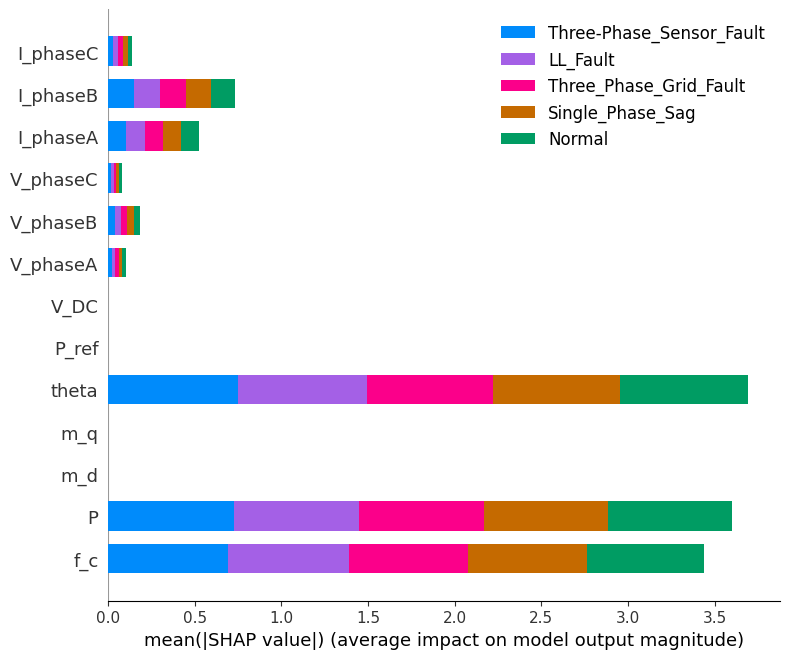

In [31]:
# shap.plots.beeswarm(shap_values)
shap.summary_plot(
    [
        np.flip(shap_values[0, :, :]),
        np.flip(shap_values[1, :, :]),
        np.flip(shap_values[2, :, :]),
        np.flip(shap_values[3, :, :]),
        np.flip(shap_values[4, :, :]),
    ],
    feature_names=lgbtest.data.columns[::-1],
    sort=False,
    class_names={
        0: "Normal",
        1: "LL_Fault",
        2: "Three-Phase_Sensor_Fault",
        3: "Single_Phase_Sag",
        4: "Three_Phase_Grid_Fault",
    },
    show=False,
)
plt.savefig(
    "shap_average_impact_on_model_output.pdf",
    format="pdf",
    dpi=600,
    bbox_inches="tight",
)
plt.show()
# shap.summary_plot(shap_values[0,:,:], features=lgbtest.data, plot_type="dot")

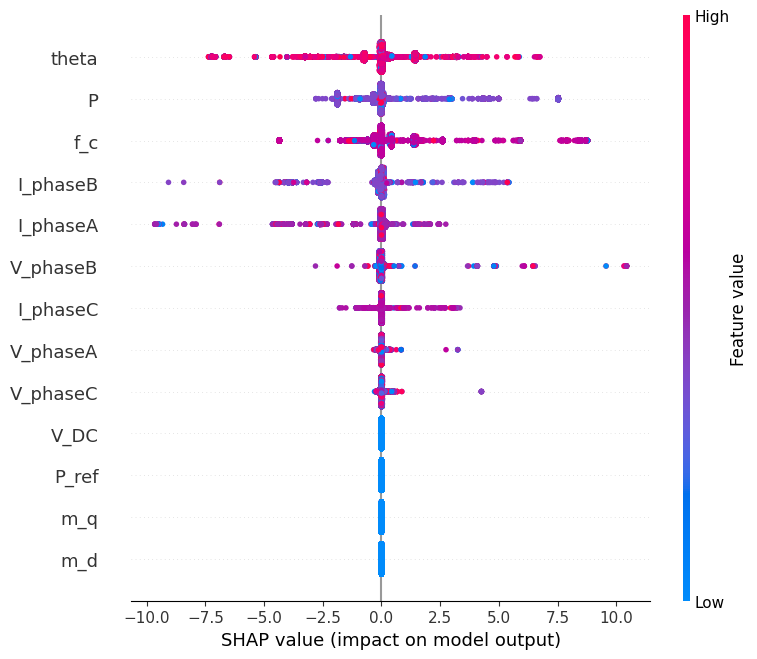

In [118]:
shap.summary_plot(
    shap_values[2, :, :], features=lgbtest.data, plot_type="dot", sort=False, show=False
)
plt.savefig(
    "shap_impact_on_model_output.pdf", format="pdf", dpi=600, bbox_inches="tight"
)
plt.show()

`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


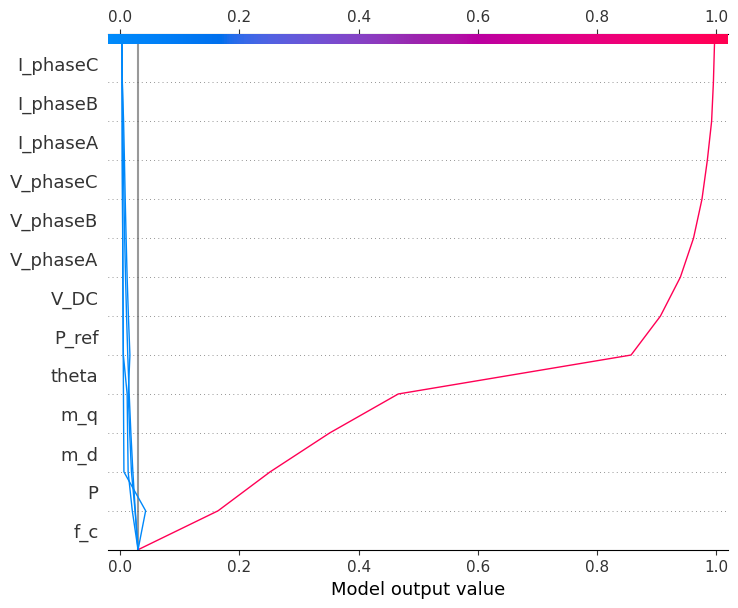

In [95]:
shap_decision_plot = shap.multioutput_decision_plot(
    base_values=list(base_value),
    shap_values=list(shap_values),
    features=model.feature_name(),
    feature_names=model.feature_name(),
    # legend_labels=legend_labels,
    link="logit",
    row_index=0,
    feature_order=list(range(len(model.feature_name()))),
)

# Deep Learning Models

In [93]:
X_train, X_valid, tab_preprocessor = utils.dl_train_prep(
    data_train=df_train_scaled,
    data_valid=df_valid_scaled,
    identifier=identifier,
    cont_cols=cont_cols,
    target_col=target,
)

test_n_valid_combined = True
# X_tab_test = tab_preprocessor.transform(data_test_scaled).astype(float)
if test_n_valid_combined:
    test = pd.concat([df_valid_scaled, df_test_scaled]).reset_index(drop=True)
else:
    test = df_test_scaled.copy()

X_test = {"X_tab": tab_preprocessor.transform(test)}

n_classes = pd.concat([df_train_scaled, df_valid_scaled, df_test_scaled])[
    target
].nunique()
metrics = utils.dl_metrics(n_classes)


input_layer = len(tab_preprocessor.continuous_cols)
output_layer = n_classes
hidden_layers = utils.dl_design(
    input_layer, 2, output_layer, design="funnel"
).hidden_layers()

Continuous columns will not be normalised


## BayesianTabMLP

In [28]:
model = BayesianTabMlp(
    mlp_hidden_dims=hidden_layers,
    column_idx=tab_preprocessor.column_idx,
    continuous_cols=tab_preprocessor.continuous_cols,
)
model

BayesianTabMlp(
  (cat_and_cont_embed): BayesianDiffSizeCatAndContEmbeddings(
    (cont_norm): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bayesian_tab_mlp): BayesianMLP(
    (bayesian_mlp): Sequential(
      (bayesian_dense_layer_0): Sequential(
        (0): BayesianLinear(7, 14, use_bias=True)
        (1): LeakyReLU(negative_slope=0.01, inplace=True)
      )
      (bayesian_dense_layer_1): Sequential(
        (0): BayesianLinear(14, 9, use_bias=True)
        (1): LeakyReLU(negative_slope=0.01, inplace=True)
      )
      (bayesian_dense_layer_2): Sequential(
        (0): BayesianLinear(9, 1, use_bias=True)
        (1): Identity()
      )
    )
  )
)

In [33]:
# Initializers/Optimizers/Schedulers/callbacks
initializers = {"deeptabular": XavierNormal}
deeptab_opt = SGD(model.bayesian_tab_mlp.parameters(), lr=0.001)
deeptab_sch = lr_scheduler.StepLR(deeptab_opt, step_size=5)
optimizers = {"deeptabular": deeptab_opt}
schedulers = {"deeptabular": deeptab_sch}

early_stopping = EarlyStopping()
model_checkpoint = ModelCheckpoint(save_best_only=True, verbose=1)

In [92]:
objective = "multiclass"
dataloader = DataLoaderImbalanced

trainer = BayesianTrainer(
    model,
    objective=objective,
    callbacks=[early_stopping, model_checkpoint],
    lr_schedulers=schedulers,
    initializers=initializers,
    optimizers=optimizers,
    metrics=metrics,
)

trainer.fit(
    X_tab=X_train["X_tab"],
    target=X_train["target"],
    val_split=0.2,
    # X_tab_val=X_valid["X_tab"],
    # target_val=X_valid["target"],
    n_epochs=50,
    batch_size=100,
    # custom_dataloader=dataloader,
    # oversample_mul=5,
)

In [ ]:
actual = test[target]
predicted = trainer.predict(**X_test)
print("Classification report:\n{}".format(classification_report(predicted, actual)))

## Transformers

In [105]:
# deeptabular = TabTransformer(input_dim=32, embed_continuous=True, column_idx=tab_preprocessor.column_idx, continuous_cols=tab_preprocessor.continuous_cols)
deeptabular = TabNet(
    embed_continuous=True,
    column_idx=tab_preprocessor.column_idx,
    continuous_cols=tab_preprocessor.continuous_cols,
)
model = WideDeep(deeptabular=deeptabular, pred_dim=output_layer)

In [106]:
# Initializers/Optimizers/Schedulers/callbacks
initializers = {"deeptabular": XavierNormal}
deeptab_opt = SGD(model.deeptabular.parameters(), lr=0.001)
deeptab_sch = lr_scheduler.StepLR(deeptab_opt, step_size=5)
optimizers = {"deeptabular": deeptab_opt}
schedulers = {"deeptabular": deeptab_sch}

early_stopping = EarlyStopping()
model_checkpoint = ModelCheckpoint(save_best_only=True, verbose=1)

In [107]:
objective = "multiclass_focal_loss"
dataloader = DataLoaderImbalanced

trainer = Trainer(
    model,
    objective=objective,
    callbacks=[early_stopping, model_checkpoint],
    lr_schedulers=schedulers,
    initializers=initializers,
    optimizers=optimizers,
    metrics=metrics,
)

trainer.fit(
    X_train=X_train,
    X_val=X_valid,
    n_epochs=50,
    batch_size=100,
    custom_dataloader=dataloader,
    oversample_mul=5,
)

  0%|          | 0/23 [00:00<?, ?it/s]

epoch 1: 100%|██████████| 23/23 [00:02<00:00, 10.57it/s, loss=0.12, metrics={'MulticlassAccuracy': [0.0565, 0.6745, 0.2604, 0.0143], 'MulticlassPrecision': 0.2523, 'MulticlassF1Score': [0.09, 0.3559, 0.2747, 0.0272], 'MulticlassRecall': [0.0565, 0.6745, 0.2604, 0.0143]}]   unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0


Epoch 00001: val_loss improved from inf to 0.11042


epoch 2: 100%|██████████| 23/23 [00:02<00:00,  9.38it/s, loss=0.12, metrics={'MulticlassAccuracy': [0.0662, 0.692, 0.2618, 0.011], 'MulticlassPrecision': 0.259, 'MulticlassF1Score': [0.1064, 0.3749, 0.2615, 0.0211], 'MulticlassRecall': [0.0662, 0.692, 0.2618, 0.011]}]      unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0


Epoch 00002: val_loss improved from 0.11042 to 0.10812


epoch 3: 100%|██████████| 23/23 [00:01<00:00, 11.97it/s, loss=0.119, metrics={'MulticlassAccuracy': [0.0484, 0.7271, 0.2431, 0.0075], 'MulticlassPrecision': 0.25, 'MulticlassF1Score': [0.0781, 0.3663, 0.2658, 0.0139], 'MulticlassRecall': [0.0484, 0.7271, 0.2431, 0.0075]}]  unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>

unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 


Epoch 00003: val_loss improved from 0.10812 to 0.10672


epoch 4: 100%|██████████| 23/23 [00:02<00:00, 10.45it/s, loss=0.121, metrics={'MulticlassAccuracy': [0.0883, 0.6806, 0.233, 0.0189], 'MulticlassPrecision': 0.2613, 'MulticlassF1Score': [0.1365, 0.3755, 0.2444, 0.0349], 'MulticlassRecall': [0.0883, 0.6806, 0.233, 0.0189]}]  unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0


Epoch 00004: val_loss improved from 0.10672 to 0.10572


epoch 5: 100%|██████████| 23/23 [00:04<00:00,  5.67it/s, loss=0.123, metrics={'MulticlassAccuracy': [0.0819, 0.663, 0.2414, 0.0233], 'MulticlassPrecision': 0.2486, 'MulticlassF1Score': [0.1326, 0.3524, 0.2414, 0.0435], 'MulticlassRecall': [0.0819, 0.663, 0.2414, 0.0233]}]  
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 


Epoch 00005: val_loss improved from 0.10572 to 0.10488


epoch 6: 100%|██████████| 23/23 [00:02<00:00,  8.03it/s, loss=0.122, metrics={'MulticlassAccuracy': [0.0603, 0.6766, 0.2181, 0.0054], 'MulticlassPrecision': 0.2441, 'MulticlassF1Score': [0.0965, 0.3637, 0.2267, 0.0104], 'MulticlassRecall': [0.0603, 0.6766, 0.2181, 0.0054]}]
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 


Epoch 00006: val_loss improved from 0.10488 to 0.10419


epoch 7: 100%|██████████| 23/23 [00:02<00:00,  9.16it/s, loss=0.121, metrics={'MulticlassAccuracy': [0.0819, 0.7159, 0.1986, 0.0073], 'MulticlassPrecision': 0.2459, 'MulticlassF1Score': [0.132, 0.3596, 0.2207, 0.0137], 'MulticlassRecall': [0.0819, 0.7159, 0.1986, 0.0073]}] unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0


Epoch 00007: val_loss improved from 0.10419 to 0.10387


epoch 8: 100%|██████████| 23/23 [00:02<00:00,  9.12it/s, loss=0.12, metrics={'MulticlassAccuracy': [0.0876, 0.6783, 0.2228, 0.0019], 'MulticlassPrecision': 0.2486, 'MulticlassF1Score': [0.1381, 0.3503, 0.2461, 0.0036], 'MulticlassRecall': [0.0876, 0.6783, 0.2228, 0.0019]}] 
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 


Epoch 00008: val_loss improved from 0.10387 to 0.10316


epoch 9: 100%|██████████| 23/23 [00:01<00:00, 12.01it/s, loss=0.121, metrics={'MulticlassAccuracy': [0.0812, 0.7013, 0.1851, 0.0072], 'MulticlassPrecision': 0.241, 'MulticlassF1Score': [0.128, 0.3705, 0.1883, 0.0139], 'MulticlassRecall': [0.0812, 0.7013, 0.1851, 0.0072]}]  unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0


Epoch 00009: val_loss improved from 0.10316 to 0.10245


epoch 10: 100%|██████████| 23/23 [00:02<00:00, 10.07it/s, loss=0.122, metrics={'MulticlassAccuracy': [0.0526, 0.712, 0.205, 0.0127], 'MulticlassPrecision': 0.2518, 'MulticlassF1Score': [0.0842, 0.3824, 0.2188, 0.0241], 'MulticlassRecall': [0.0526, 0.712, 0.205, 0.0127]}]    unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 


Epoch 00010: val_loss improved from 0.10245 to 0.10086


epoch 11: 100%|██████████| 23/23 [00:02<00:00,  9.69it/s, loss=0.121, metrics={'MulticlassAccuracy': [0.0676, 0.6836, 0.2358, 0.0074], 'MulticlassPrecision': 0.25, 'MulticlassF1Score': [0.1076, 0.3569, 0.2558, 0.0141], 'MulticlassRecall': [0.0676, 0.6836, 0.2358, 0.0074]}]  
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at


Epoch 00011: val_loss improved from 0.10086 to 0.10024


epoch 12: 100%|██████████| 23/23 [00:01<00:00, 12.22it/s, loss=0.123, metrics={'MulticlassAccuracy': [0.0888, 0.7078, 0.1955, 0.0054], 'MulticlassPrecision': 0.2428, 'MulticlassF1Score': [0.1422, 0.3554, 0.2135, 0.0103], 'MulticlassRecall': [0.0888, 0.7078, 0.1955, 0.0054]}]unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 


Epoch 00012: val_loss improved from 0.10024 to 0.09943


epoch 13: 100%|██████████| 23/23 [00:02<00:00, 10.22it/s, loss=0.124, metrics={'MulticlassAccuracy': [0.082, 0.6679, 0.2412, 0.0143], 'MulticlassPrecision': 0.2482, 'MulticlassF1Score': [0.1261, 0.3538, 0.2507, 0.0271], 'MulticlassRecall': [0.082, 0.6679, 0.2412, 0.0143]}]  unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>

unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at


Epoch 00013: val_loss improved from 0.09943 to 0.09830


epoch 14: 100%|██████████| 23/23 [00:02<00:00,  9.84it/s, loss=0.122, metrics={'MulticlassAccuracy': [0.0764, 0.7304, 0.2106, 0.012], 'MulticlassPrecision': 0.2554, 'MulticlassF1Score': [0.1245, 0.3837, 0.2155, 0.0227], 'MulticlassRecall': [0.0764, 0.7304, 0.2106, 0.012]}]  unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 


Epoch 00014: val_loss improved from 0.09830 to 0.09699


epoch 15: 100%|██████████| 23/23 [00:02<00:00,  9.39it/s, loss=0.121, metrics={'MulticlassAccuracy': [0.0693, 0.7094, 0.2028, 0.0093], 'MulticlassPrecision': 0.2509, 'MulticlassF1Score': [0.1126, 0.3711, 0.2199, 0.0177], 'MulticlassRecall': [0.0693, 0.7094, 0.2028, 0.0093]}]unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 


Epoch 00015: val_loss improved from 0.09699 to 0.09689


epoch 16: 100%|██████████| 23/23 [00:02<00:00, 11.37it/s, loss=0.122, metrics={'MulticlassAccuracy': [0.0796, 0.6901, 0.2208, 0.0107], 'MulticlassPrecision': 0.2586, 'MulticlassF1Score': [0.1224, 0.3784, 0.2361, 0.0203], 'MulticlassRecall': [0.0796, 0.6901, 0.2208, 0.0107]}]
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at


Epoch 00016: val_loss did not improve from 0.09689


epoch 17: 100%|██████████| 23/23 [00:01<00:00, 12.01it/s, loss=0.121, metrics={'MulticlassAccuracy': [0.0874, 0.6597, 0.2474, 0.016], 'MulticlassPrecision': 0.2473, 'MulticlassF1Score': [0.1331, 0.3449, 0.2618, 0.0299], 'MulticlassRecall': [0.0874, 0.6597, 0.2474, 0.016]}]  unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 


Epoch 00017: val_loss did not improve from 0.09689


epoch 18: 100%|██████████| 23/23 [00:01<00:00, 12.40it/s, loss=0.121, metrics={'MulticlassAccuracy': [0.081, 0.6847, 0.192, 0.0037], 'MulticlassPrecision': 0.2473, 'MulticlassF1Score': [0.1267, 0.3646, 0.2126, 0.0071], 'MulticlassRecall': [0.081, 0.6847, 0.192, 0.0037]}]    unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 


Epoch 00018: val_loss did not improve from 0.09689


epoch 19: 100%|██████████| 23/23 [00:01<00:00, 13.78it/s, loss=0.122, metrics={'MulticlassAccuracy': [0.0826, 0.7004, 0.2213, 0.0038], 'MulticlassPrecision': 0.2527, 'MulticlassF1Score': [0.1316, 0.3591, 0.2442, 0.0074], 'MulticlassRecall': [0.0826, 0.7004, 0.2213, 0.0038]}]unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 


Epoch 00019: val_loss did not improve from 0.09689


epoch 20: 100%|██████████| 23/23 [00:01<00:00, 12.47it/s, loss=0.125, metrics={'MulticlassAccuracy': [0.0805, 0.6939, 0.2478, 0.0073], 'MulticlassPrecision': 0.25, 'MulticlassF1Score': [0.1318, 0.3566, 0.2532, 0.0137], 'MulticlassRecall': [0.0805, 0.6939, 0.2478, 0.0073]}]  
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at


Epoch 00020: val_loss did not improve from 0.09689


epoch 21: 100%|██████████| 23/23 [00:01<00:00, 13.58it/s, loss=0.12, metrics={'MulticlassAccuracy': [0.0645, 0.6809, 0.2329, 0.009], 'MulticlassPrecision': 0.2495, 'MulticlassF1Score': [0.1043, 0.3643, 0.2418, 0.0171], 'MulticlassRecall': [0.0645, 0.6809, 0.2329, 0.009]}]   
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at


Epoch 00021: val_loss did not improve from 0.09689


epoch 22: 100%|██████████| 23/23 [00:01<00:00, 13.44it/s, loss=0.124, metrics={'MulticlassAccuracy': [0.0827, 0.687, 0.2345, 0.0224], 'MulticlassPrecision': 0.2658, 'MulticlassF1Score': [0.1314, 0.3786, 0.2456, 0.0422], 'MulticlassRecall': [0.0827, 0.687, 0.2345, 0.0224]}]  unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 


Epoch 00022: val_loss did not improve from 0.09689


epoch 23: 100%|██████████| 23/23 [00:01<00:00, 12.97it/s, loss=0.123, metrics={'MulticlassAccuracy': [0.0861, 0.6703, 0.2372, 0.0074], 'MulticlassPrecision': 0.2505, 'MulticlassF1Score': [0.1352, 0.3572, 0.246, 0.0141], 'MulticlassRecall': [0.0861, 0.6703, 0.2372, 0.0074]}] unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>

unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at


Epoch 00023: val_loss did not improve from 0.09689


epoch 24: 100%|██████████| 23/23 [00:01<00:00, 12.73it/s, loss=0.121, metrics={'MulticlassAccuracy': [0.0756, 0.6868, 0.2555, 0.0071], 'MulticlassPrecision': 0.2577, 'MulticlassF1Score': [0.1211, 0.3719, 0.259, 0.0134], 'MulticlassRecall': [0.0756, 0.6868, 0.2555, 0.0071]}] unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 


Epoch 00024: val_loss did not improve from 0.09689


epoch 25: 100%|██████████| 23/23 [00:01<00:00, 13.95it/s, loss=0.121, metrics={'MulticlassAccuracy': [0.0795, 0.6389, 0.2593, 0.0074], 'MulticlassPrecision': 0.2509, 'MulticlassF1Score': [0.1275, 0.3533, 0.2584, 0.0141], 'MulticlassRecall': [0.0795, 0.6389, 0.2593, 0.0074]}]unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 


Epoch 00025: val_loss did not improve from 0.09689


unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>


Model weights restored to best epoch: 15


In [108]:
# TabNet
y_onehot_test = pd.get_dummies(test[target]).values
y_score = trainer.predict_proba(**X_test)

micro_roc_auc_ovr_per_class = roc_auc_score(
    y_onehot_test,
    y_score,
    multi_class="ovr",
    average=None,
)

micro_roc_auc_ovr_weighted = roc_auc_score(
    y_onehot_test,
    y_score,
    multi_class="ovr",
    average="weighted",
)

print(f"Per class AUC:\n{micro_roc_auc_ovr_per_class}")
print(f"Weighted AUC:\n{micro_roc_auc_ovr_weighted}")

predict: 100%|██████████| 37/37 [00:02<00:00, 17.84it/s]unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>

unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>


Per class AUC:
[0.49754326 0.48879157 0.47781304 0.61500768]
Weighted AUC:
0.4967644461112033


In [109]:
actual = test[target]
predicted = trainer.predict(**X_test)
print("Classification report:\n{}".format(classification_report(predicted, actual)))

predict: 100%|██████████| 37/37 [00:01<00:00, 22.05it/s]unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>



Classification report:
              precision    recall  f1-score   support

           0       0.08      0.75      0.15       257
           1       0.58      0.11      0.19      2269
           2       0.29      0.20      0.24      1103
           3       0.02      0.05      0.03        63

    accuracy                           0.18      3692
   macro avg       0.24      0.28      0.15      3692
weighted avg       0.45      0.18      0.20      3692



In [103]:
# TabTransformer
y_onehot_test = pd.get_dummies(test[target]).values
y_score = trainer.predict_proba(**X_test)

micro_roc_auc_ovr_per_class = roc_auc_score(
    y_onehot_test,
    y_score,
    multi_class="ovr",
    average=None,
)

micro_roc_auc_ovr_weighted = roc_auc_score(
    y_onehot_test,
    y_score,
    multi_class="ovr",
    average="weighted",
)

print(f"Per class AUC:\n{micro_roc_auc_ovr_per_class}")
print(f"Weighted AUC:\n{micro_roc_auc_ovr_weighted}")

  0%|          | 0/37 [00:00<?, ?it/s]

predict: 100%|██████████| 37/37 [00:02<00:00, 13.83it/s]
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>


Per class AUC:
[0.48588412 0.41101402 0.42557068 0.52638868]
Weighted AUC:
0.4656837640810216


In [98]:
actual = test[target]
predicted = trainer.predict(**X_test)
print("Classification report:\n{}".format(classification_report(predicted, actual)))

predict: 100%|██████████| 37/37 [00:02<00:00, 17.16it/s]unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88eb60>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f383b88ec80>



Classification report:
              precision    recall  f1-score   support

           0       0.00      0.01      0.00       105
           1       0.08      0.06      0.07       634
           2       0.29      0.15      0.20      1481
           3       0.49      0.05      0.08      1472

    accuracy                           0.09      3692
   macro avg       0.22      0.07      0.09      3692
weighted avg       0.33      0.09      0.13      3692



## TabMLP

In [58]:
deeptabular_net = TabMlp(
    mlp_hidden_dims=hidden_layers,
    column_idx=tab_preprocessor.column_idx,
    continuous_cols=tab_preprocessor.continuous_cols,
    mlp_batchnorm=True,
    mlp_batchnorm_last=True,
    mlp_linear_first=True,
)
model = WideDeep(deeptabular=deeptabular_net, pred_dim=output_layer)
model

WideDeep(
  (deeptabular): Sequential(
    (0): TabMlp(
      (cat_and_cont_embed): DiffSizeCatAndContEmbeddings(
        (cont_norm): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (encoder): MLP(
        (mlp): Sequential(
          (dense_layer_0): Sequential(
            (0): Linear(in_features=7, out_features=14, bias=False)
            (1): ReLU(inplace=True)
            (2): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): Dropout(p=0.1, inplace=False)
          )
          (dense_layer_1): Sequential(
            (0): Linear(in_features=14, out_features=9, bias=False)
            (1): ReLU(inplace=True)
            (2): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    (1): Linear(in_features=9, out_features=4, bias=True)
  )
)

In [59]:
# Initializers/Optimizers/Schedulers/callbacks
initializers = {"deeptabular": XavierNormal}
deeptab_opt = SGD(model.deeptabular.parameters(), lr=0.001)
deeptab_sch = lr_scheduler.StepLR(deeptab_opt, step_size=5)
optimizers = {"deeptabular": deeptab_opt}
schedulers = {"deeptabular": deeptab_sch}

early_stopping = EarlyStopping()
model_checkpoint = ModelCheckpoint(save_best_only=True, verbose=1)

In [26]:
objective = "multiclass_focal_loss"
dataloader = DataLoaderImbalanced

trainer = Trainer(
    model,
    objective=objective,
    callbacks=[early_stopping, model_checkpoint],
    lr_schedulers=schedulers,
    initializers=initializers,
    optimizers=optimizers,
    metrics=metrics,
)

trainer.fit(
    X_train=X_train,
    X_val=X_valid,
    n_epochs=50,
    batch_size=100,
    custom_dataloader=dataloader,
    oversample_mul=5,
)

epoch 1: 100%|██████████| 32/32 [00:01<00:00, 19.22it/s, loss=0.256, metrics={'MulticlassAccuracy': [0.2086, 0.2988, 0.4542, 0.2727], 'MulticlassPrecision': 0.3094, 'MulticlassF1Score': [0.2421, 0.3458, 0.3492, 0.2806], 'MulticlassRecall': [0.2086, 0.2988, 0.4542, 0.2727]}]unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>

unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
valid: 100%|██████████| 24/24 [00:01<00:00, 19.48it/s, loss=0.219, metrics={'MulticlassAccuracy': [0.257, 0.2356, 0.472, 0.31], 'MulticlassPrecision': 0.3004, 'MulticlassF1Score': [0.3681, 0.2721, 0.3028, 0.1044], 'MulticlassRecall': [0.257, 0.2356, 0.472, 0.31]}]     


Epoch 00001: val_loss did not improve from 0.12159


epoch 2: 100%|██████████| 32/32 [00:01<00:00, 24.51it/s, loss=0.259, metrics={'MulticlassAccuracy': [0.2193, 0.2759, 0.4613, 0.2556], 'MulticlassPrecision': 0.3034, 'MulticlassF1Score': [0.2529, 0.331, 0.3452, 0.2635], 'MulticlassRecall': [0.2193, 0.2759, 0.4613, 0.2556]}] 
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
valid: 100%|██████████| 24/24 [00:00<00:00, 30.85it/s, loss=0.226, metrics={'MulticlassAccuracy': [0.2463, 0.2481, 0.514, 0.27], 'MulticlassPrecision': 0.3033, 'MulticlassF1Score': [0.3581, 0.2585, 0.3251, 0.1027], 'MulticlassRecall': [0.2463, 0.2481, 0.514, 0.27]}]   


Epoch 00002: val_loss did not improve from 0.12159


epoch 3: 100%|██████████| 32/32 [00:01<00:00, 26.86it/s, loss=0.257, metrics={'MulticlassAccuracy': [0.1848, 0.3022, 0.4396, 0.2951], 'MulticlassPrecision': 0.3063, 'MulticlassF1Score': [0.2116, 0.3583, 0.3278, 0.3104], 'MulticlassRecall': [0.1848, 0.3022, 0.4396, 0.2951]}]unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>

unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
valid: 100%|██████████| 24/24 [00:01<00:00, 23.73it/s, loss=0.229, metrics={'MulticlassAccuracy': [0.252, 0.2431, 0.464, 0.31], 'MulticlassPrecision': 0.2971, 'MulticlassF1Score': [0.3619, 0.2453, 0.3023, 0.1185], 'MulticlassRecall': [0.252, 0.2431, 0.464, 0.31]}]     


Epoch 00003: val_loss did not improve from 0.12159


epoch 4: 100%|██████████| 32/32 [00:01<00:00, 23.32it/s, loss=0.254, metrics={'MulticlassAccuracy': [0.2355, 0.3152, 0.491, 0.2602], 'MulticlassPrecision': 0.3275, 'MulticlassF1Score': [0.2715, 0.3572, 0.3806, 0.2773], 'MulticlassRecall': [0.2355, 0.3152, 0.491, 0.2602]}]  
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
valid: 100%|██████████| 24/24 [00:01<00:00, 21.98it/s, loss=0.234, metrics={'MulticlassAccuracy': [0.2398, 0.2481, 0.524, 0.29], 'MulticlassPrecision': 0.3025, 'MulticlassF1Score': [0.3498, 0.2418, 0.3296, 0.1234], 'MulticlassRecall': [0.2398, 0.2481, 0.524, 0.29]}]   


Epoch 00004: val_loss did not improve from 0.12159


epoch 5: 100%|██████████| 32/32 [00:01<00:00, 24.70it/s, loss=0.257, metrics={'MulticlassAccuracy': [0.2254, 0.2857, 0.4492, 0.25], 'MulticlassPrecision': 0.3016, 'MulticlassF1Score': [0.2633, 0.3433, 0.3286, 0.2588], 'MulticlassRecall': [0.2254, 0.2857, 0.4492, 0.25]}]    unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>

unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
valid: 100%|██████████| 24/24 [00:01<00:00, 22.70it/s, loss=0.229, metrics={'MulticlassAccuracy': [0.2498, 0.2506, 0.464, 0.28], 'MulticlassPrecision': 0.2958, 'MulticlassF1Score': [0.3582, 0.2457, 0.3033, 0.1116], 'MulticlassRecall': [0.2498, 0.2506, 0.464, 0.28]}]   


Epoch 00005: val_loss did not improve from 0.12159


epoch 6: 100%|██████████| 32/32 [00:01<00:00, 25.14it/s, loss=0.255, metrics={'MulticlassAccuracy': [0.2304, 0.2878, 0.4489, 0.2722], 'MulticlassPrecision': 0.3116, 'MulticlassF1Score': [0.2703, 0.3386, 0.3488, 0.2715], 'MulticlassRecall': [0.2304, 0.2878, 0.4489, 0.2722]}]unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>

unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
valid: 100%|██████████| 24/24 [00:01<00:00, 21.73it/s, loss=0.234, metrics={'MulticlassAccuracy': [0.242, 0.2381, 0.526, 0.33], 'MulticlassPrecision': 0.3042, 'MulticlassF1Score': [0.3544, 0.2523, 0.3314, 0.1207], 'MulticlassRecall': [0.242, 0.2381, 0.526, 0.33]}]     


Epoch 00006: val_loss did not improve from 0.12159


epoch 7: 100%|██████████| 32/32 [00:01<00:00, 27.36it/s, loss=0.254, metrics={'MulticlassAccuracy': [0.2124, 0.3027, 0.4988, 0.274], 'MulticlassPrecision': 0.3222, 'MulticlassF1Score': [0.2474, 0.3583, 0.3672, 0.292], 'MulticlassRecall': [0.2124, 0.3027, 0.4988, 0.274]}]   
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
valid: 100%|██████████| 24/24 [00:00<00:00, 29.10it/s, loss=0.225, metrics={'MulticlassAccuracy': [0.2484, 0.2456, 0.492, 0.26], 'MulticlassPrecision': 0.2992, 'MulticlassF1Score': [0.3582, 0.2506, 0.313, 0.1034], 'MulticlassRecall': [0.2484, 0.2456, 0.492, 0.26]}]    


Epoch 00007: val_loss did not improve from 0.12159


epoch 8: 100%|██████████| 32/32 [00:00<00:00, 32.73it/s, loss=0.256, metrics={'MulticlassAccuracy': [0.21, 0.2682, 0.446, 0.2494], 'MulticlassPrecision': 0.2909, 'MulticlassF1Score': [0.2526, 0.3107, 0.3269, 0.2597], 'MulticlassRecall': [0.21, 0.2682, 0.446, 0.2494]}]      
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
valid: 100%|██████████| 24/24 [00:00<00:00, 35.23it/s, loss=0.23, metrics={'MulticlassAccuracy': [0.2455, 0.2481, 0.502, 0.29], 'MulticlassPrecision': 0.3013, 'MulticlassF1Score': [0.3557, 0.2503, 0.3151, 0.1203], 'MulticlassRecall': [0.2455, 0.2481, 0.502, 0.29]}]    


Epoch 00008: val_loss did not improve from 0.12159


epoch 9: 100%|██████████| 32/32 [00:00<00:00, 33.51it/s, loss=0.256, metrics={'MulticlassAccuracy': [0.2125, 0.2912, 0.4143, 0.3056], 'MulticlassPrecision': 0.3053, 'MulticlassF1Score': [0.248, 0.3449, 0.3172, 0.3066], 'MulticlassRecall': [0.2125, 0.2912, 0.4143, 0.3056]}] 
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
valid: 100%|██████████| 24/24 [00:00<00:00, 34.16it/s, loss=0.228, metrics={'MulticlassAccuracy': [0.2491, 0.2456, 0.51, 0.29], 'MulticlassPrecision': 0.3046, 'MulticlassF1Score': [0.3576, 0.2589, 0.3202, 0.1165], 'MulticlassRecall': [0.2491, 0.2456, 0.51, 0.29]}]     


Epoch 00009: val_loss did not improve from 0.12159


epoch 10: 100%|██████████| 32/32 [00:00<00:00, 35.47it/s, loss=0.258, metrics={'MulticlassAccuracy': [0.2134, 0.3002, 0.4665, 0.2679], 'MulticlassPrecision': 0.3131, 'MulticlassF1Score': [0.2411, 0.3548, 0.3567, 0.2787], 'MulticlassRecall': [0.2134, 0.3002, 0.4665, 0.2679]}]
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
valid: 100%|██████████| 24/24 [00:00<00:00, 31.96it/s, loss=0.234, metrics={'MulticlassAccuracy': [0.2391, 0.2431, 0.514, 0.32], 'MulticlassPrecision': 0.3004, 'MulticlassF1Score': [0.3481, 0.2416, 0.3239, 0.132], 'MulticlassRecall': [0.2391, 0.2431, 0.514, 0.32]}]   


Epoch 00010: val_loss did not improve from 0.12159


epoch 11: 100%|██████████| 32/32 [00:00<00:00, 35.72it/s, loss=0.257, metrics={'MulticlassAccuracy': [0.2434, 0.306, 0.4613, 0.2736], 'MulticlassPrecision': 0.3219, 'MulticlassF1Score': [0.2672, 0.3661, 0.3514, 0.2897], 'MulticlassRecall': [0.2434, 0.306, 0.4613, 0.2736]}]  unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>

unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
valid: 100%|██████████| 24/24 [00:00<00:00, 36.42it/s, loss=0.226, metrics={'MulticlassAccuracy': [0.2548, 0.2431, 0.502, 0.29], 'MulticlassPrecision': 0.3058, 'MulticlassF1Score': [0.3662, 0.2583, 0.3199, 0.1094], 'MulticlassRecall': [0.2548, 0.2431, 0.502, 0.29]}]  


Epoch 00011: val_loss did not improve from 0.12159
Model weights restored to best epoch: 1


In [27]:
actual = test[target]
predicted = trainer.predict(**X_test)
print("Classification report:\n{}".format(classification_report(predicted, actual)))

predict:  92%|█████████▏| 45/49 [00:00<00:00, 82.50it/s]unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f2d1892a5c0>
predict:  98%|█████████▊| 48/49 [00:00<00:00, 54.95it/s]


Classification report:
              precision    recall  f1-score   support

           0       0.27      0.67      0.39      1129
           1       0.26      0.30      0.28       697
           2       0.50      0.24      0.32      2124
           3       0.27      0.06      0.10       850

    accuracy                           0.32      4800
   macro avg       0.33      0.32      0.27      4800
weighted avg       0.37      0.32      0.29      4800



## w RayTune

In [1]:
# Optimizers
deep_opt_sgd_01 = SGD(model.deeptabular.parameters(), lr=0.1)
deep_opt_sgd_001 = SGD(model.deeptabular.parameters(), lr=0.01)
deep_opt_adam_01 = Adam(model.deeptabular.parameters(), lr=0.1)
deep_opt_adam_001 = Adam(model.deeptabular.parameters(), lr=0.01)
# LR Schedulers
deep_sch_StepLR5 = lr_scheduler.StepLR(deep_opt_sgd_01, step_size=5)
deep_sch_StepLR10 = lr_scheduler.StepLR(deep_opt_sgd_01, step_size=10)

input_layer = len(tab_preprocessor.continuous_cols)
output_layer = n_classes

hidden_layers2 = utils.dl_design(input_layer, 2, output_layer, design="funnel")
hidden_layers3 = utils.dl_design(input_layer, 3, output_layer, design="funnel")
hidden_layers5 = utils.dl_design(input_layer, 5, output_layer, design="funnel")
hidden_layers10 = utils.dl_design(input_layer, 10, output_layer, design="funnel")

config = {
    "batch_size": tune.grid_search([100, 1000, 10000]),
    "deeptab_opt": tune.grid_search(
        [
            deep_opt_sgd_01,
            deep_opt_adam_01,
            deep_opt_sgd_001,
            deep_opt_adam_001,
        ]
    ),
    "deeptab_sch": tune.grid_search([deep_sch_StepLR5, deep_sch_StepLR10]),
    "hidden_layers": tune.grid_search(
        [hidden_layers2, hidden_layers3, hidden_layers5, hidden_layers10]
    ),
    "wandb": {
        "project": "dl_mlp_ecce",
        "api_key_file": "wandb_api.key",
    },
}

objective = "multiclass_focal_loss"
dataloader = DataLoaderImbalanced


@wandb_mixin
def training_function(config, X_train, X_val):
    early_stopping = EarlyStopping()
    model_checkpoint = ModelCheckpoint(save_best_only=True, wb=wandb)

    deeptabular = TabMlp(
        mlp_hidden_dims=config["hidden_layers"].hidden_layers(),
        column_idx=tab_preprocessor.column_idx,
        embed_input=tab_preprocessor.embeddings_input,
        continuous_cols=tab_preprocessor.continuous_cols,
        mlp_batchnorm=True,
        mlp_batchnorm_last=True,
        mlp_linear_first=True,
    )

    model = WideDeep(deeptabular=deeptabular)

    trainer = Trainer(
        model,
        objective=objective,
        callbacks=[RayTuneReporter, early_stopping, model_checkpoint],
        lr_schedulers={"deeptabular": config["deeptab_sch"]},
        initializers={"deeptabular": XavierNormal},
        optimizers={"deeptabular": config["deeptab_opt"]},
        metrics=metrics,
        verbose=0,
    )

    trainer.fit(
        X_train=X_train,
        X_val=X_valid,
        n_epochs=50,
        batch_size=config["batch_size"],
        custom_dataloader=dataloader,
        oversample_mul=5,
    )


# https://docs.ray.io/en/latest/tune/api_docs/schedulers.html#tune-scheduler-hyperband
asha_scheduler = AsyncHyperBandScheduler(
    time_attr="training_iteration",
    metric="_metric/val_loss",
    mode="min",
    max_t=100,
    grace_period=10,
    reduction_factor=3,
    brackets=1,
)

analysis = tune.run(
    tune.with_parameters(training_function, X_train=X_train, X_val=X_valid),
    # resources_per_trial={"cpu": 4, "gpu": 0},
    num_samples=1,
    progress_reporter=JupyterNotebookReporter(overwrite=True),
    scheduler=asha_scheduler,
    config=config,
    callbacks=[
        WandbLoggerCallback(
            project=config["wandb"]["project"],
            api_key_file=config["wandb"]["api_key_file"],
            log_config=True,
        )
    ],
)

### Train the Best model

In [ ]:
%%time
params = copy(analysis.get_best_config("_metric/val_loss", "min"))
params.pop("wandb")

trainer = Trainer(
    model,
    objective=objective,
    callbacks=[LRHistory(n_epochs=10)],
    lr_schedulers={"wide": params["wide_sch"], "deeptabular": params["deeptab_sch"]},
    initializers={"wide": XavierNormal, "deeptabular": XavierNormal},
    optimizers={"wide": params["wide_opt"], "deeptabular": params["deeptab_opt"]},
    metrics=metrics,
    verbose=0,
)

trainer.fit(
    X_train=X_train,
    X_val=X_val,
    n_epochs=5,
    batch_size=params["batch_size"],
    custom_dataloader=dataloader,
    oversample_mul=5,
)